In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
os.getcwd()
os.chdir(r'C:\Users\adria\Desktop')

In [27]:
df = pd.read_csv(r'C:\Users\adria\Desktop\DGS10.csv')

In [28]:
df = df.set_index('DATE')

In [29]:
df.index = pd.to_datetime(df.index)
df['DGS10'] = pd.to_numeric(df['DGS10'], errors='coerce')

In [30]:
df.head

<bound method NDFrame.head of             DGS10
DATE             
1962-01-02   4.06
1962-01-03   4.03
1962-01-04   3.99
1962-01-05   4.02
1962-01-08   4.03
...           ...
2024-08-30   3.91
2024-09-02    NaN
2024-09-03   3.84
2024-09-04   3.77
2024-09-05   3.73

[16353 rows x 1 columns]>

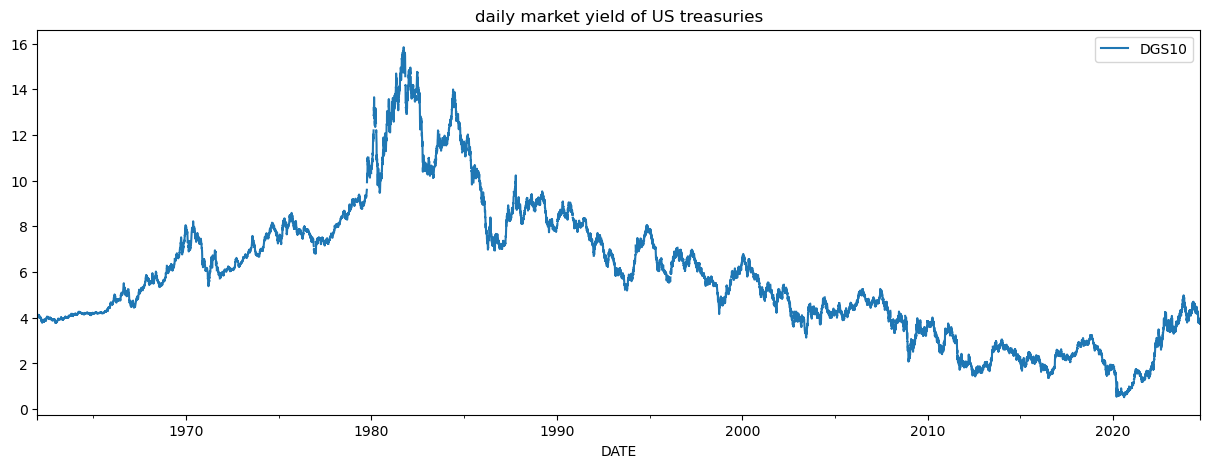

In [31]:
df.plot(style = '',
        figsize = (15,5),
        color=color_pal[0],
        title = 'daily market yield of US treasuries')
plt.show()

<Axes: ylabel='Frequency'>

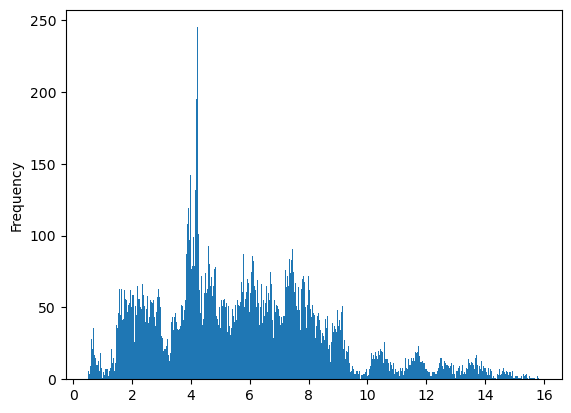

In [32]:
df['DGS10'].plot(kind= 'hist', bins=500)

In [26]:
from sklearn.model_selection import TimeSeriesSplit

<function matplotlib.pyplot.show(close=None, block=None)>

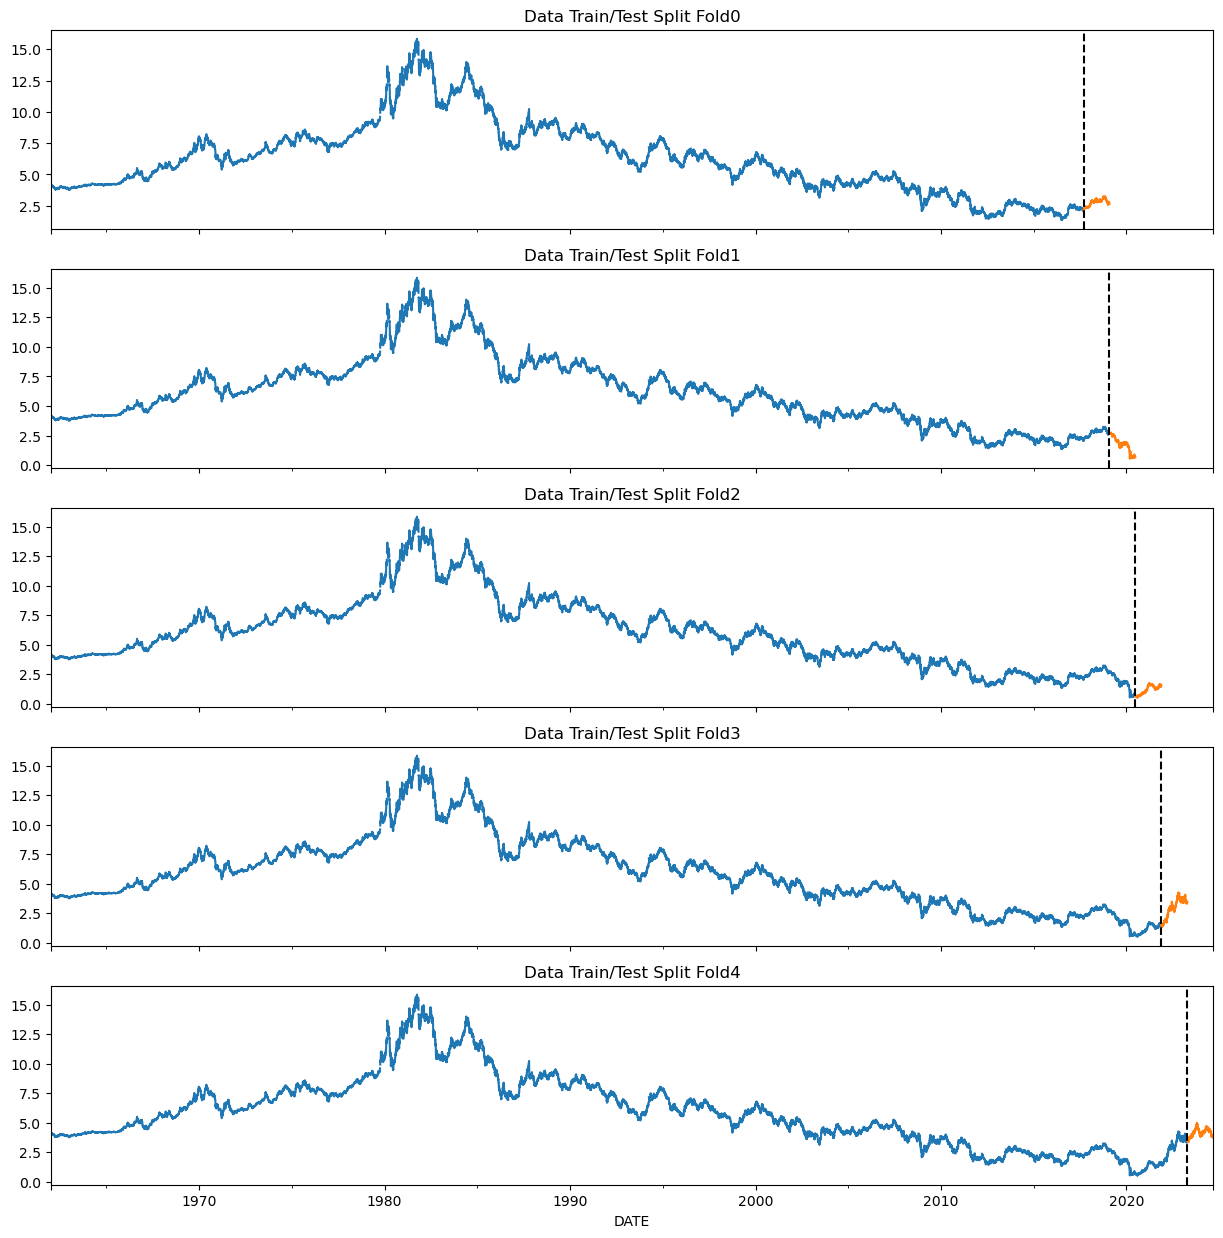

In [43]:
fig, axs = plt.subplots(5,1, figsize = (15,15),
                             sharex = True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['DGS10'].plot(ax=axs[fold],
    label ='Training Set', title = f'Data Train/Test Split Fold{fold}')
    test['DGS10'].plot(ax=axs[fold], label = 'Test Set')
    axs[fold].axvline(test.index.min(), color = 'black', ls = '--')
    fold +=1
plt.show

In [44]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)



In [48]:
def add_lags(df):
    target_map = df['DGS10'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [49]:
df = add_lags(df)



In [50]:
df.head()

,DGS10,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
DATE,,,,,,,,,,,
1962-01-02,4.06,1,1,1,1962,2,2,1,NaN,NaN,NaN
1962-01-03,4.03,2,1,1,1962,3,3,1,NaN,NaN,NaN
1962-01-04,3.99,3,1,1,1962,4,4,1,NaN,NaN,NaN
1962-01-05,4.02,4,1,1,1962,5,5,1,NaN,NaN,NaN
1962-01-08,4.03,0,1,1,1962,8,8,2,NaN,NaN,NaN


In [53]:
tss = TimeSeriesSplit(n_splits=5, test_size=365*1, gap=1)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx].dropna(subset=['DGS10'])
    test = df.iloc[val_idx].dropna(subset=['DGS10'])

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'DGS10'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:6.37475	validation_1-rmse:2.27164
[100]	validation_0-rmse:2.45706	validation_1-rmse:1.18576
[200]	validation_0-rmse:1.10092	validation_1-rmse:0.82659


C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:10:09] WARNING: D:\bld\xgboost-split_1713397727666\work\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.67440	validation_1-rmse:0.65300
[400]	validation_0-rmse:0.54866	validation_1-rmse:0.59191
[470]	validation_0-rmse:0.51138	validation_1-rmse:0.59194
[0]	validation_0-rmse:6.30640	validation_1-rmse:1.36517
[100]	validation_0-rmse:2.43186	validation_1-rmse:0.64574
[155]	validation_0-rmse:1.51631	validation_1-rmse:0.68765
[0]	validation_0-rmse:6.23360	validation_1-rmse:0.76794


C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:10:09] WARNING: D:\bld\xgboost-split_1713397727666\work\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:10:09] WARNING: D:\bld\xgboost-split_1713397727666\work\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2.40628	validation_1-rmse:0.44622
[109]	validation_0-rmse:2.21849	validation_1-rmse:0.47232
[0]	validation_0-rmse:6.16116	validation_1-rmse:2.58398
[100]	validation_0-rmse:2.38110	validation_1-rmse:1.99717
[200]	validation_0-rmse:1.07099	validation_1-rmse:1.81735


C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:10:10] WARNING: D:\bld\xgboost-split_1713397727666\work\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.67937	validation_1-rmse:1.67046
[400]	validation_0-rmse:0.55133	validation_1-rmse:1.62338
[499]	validation_0-rmse:0.50516	validation_1-rmse:1.59143
[0]	validation_0-rmse:6.10283	validation_1-rmse:3.66253
[100]	validation_0-rmse:2.36634	validation_1-rmse:2.50340
[200]	validation_0-rmse:1.07890	validation_1-rmse:1.94619


C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:10:10] WARNING: D:\bld\xgboost-split_1713397727666\work\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:0.68811	validation_1-rmse:1.56163
[400]	validation_0-rmse:0.56354	validation_1-rmse:1.37529
[500]	validation_0-rmse:0.51450	validation_1-rmse:1.30918
[600]	validation_0-rmse:0.49001	validation_1-rmse:1.25832
[700]	validation_0-rmse:0.47231	validation_1-rmse:1.22224
[800]	validation_0-rmse:0.45393	validation_1-rmse:1.18824
[900]	validation_0-rmse:0.43822	validation_1-rmse:1.16987
[999]	validation_0-rmse:0.42417	validation_1-rmse:1.16228


In [54]:
scores

[0.5862936208227393,
 0.6444895244426212,
 0.3721376108200877,
 1.5878435868460834,
 1.1611851225674883]

In [55]:


print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')



Score across folds 0.8704
Fold scores:[0.5862936208227393, 0.6444895244426212, 0.3721376108200877, 1.5878435868460834, 1.1611851225674883]


In [57]:
print(df['DGS10'].isna().sum())  # Check for NaN values
print(np.isinf(df['DGS10']).sum())  # Check for infinite values

697
0


In [58]:
df['DGS10'] = df['DGS10'].fillna(df['DGS10'].mean())  # Replace NaNs with the mean

In [59]:
df = create_features(df)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'DGS10'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:6.02869
[100]	validation_0-rmse:2.38413


C:\Users\adria\miniconda3\envs\tensorflow-env\lib\site-packages\xgboost\core.py:160: UserWarning: [12:04:17] WARNING: D:\bld\xgboost-split_1713397727666\work\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:1.17630
[300]	validation_0-rmse:0.85190
[400]	validation_0-rmse:0.76073
[499]	validation_0-rmse:0.72624


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [60]:
df.index.max()

Timestamp('2024-09-05 00:00:00')

In [77]:
future = pd.date_range('2024-09-05', '2025-09-01', freq = 'D')

In [78]:
future_df = pd.DataFrame(index = future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [79]:
future_w_features = df_and_future.query('isFuture').copy()

In [80]:
future_w_features

,DGS10,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2024-09-05,NaN,3,3,9,2024,249,5,36,4.270000,3.290000,1.300000,True
2024-09-06,NaN,4,3,9,2024,250,6,36,4.260000,3.330000,1.350000,True
2024-09-07,NaN,5,3,9,2024,251,7,36,NaN,NaN,NaN,True
2024-09-08,NaN,6,3,9,2024,252,8,36,NaN,NaN,NaN,True
2024-09-09,NaN,0,3,9,2024,253,9,37,4.290000,3.370000,1.330000,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-28,NaN,3,3,8,2025,240,28,35,3.870000,4.090000,3.260000,True
2025-08-29,NaN,4,3,8,2025,241,29,35,3.910000,4.180000,3.200000,True
2025-08-30,NaN,5,3,8,2025,242,30,35,NaN,NaN,NaN,True
2025-08-31,NaN,6,3,8,2025,243,31,35,NaN,NaN,NaN,True


In [81]:


future_w_features['pred'] = reg.predict(future_w_features[FEATURES])



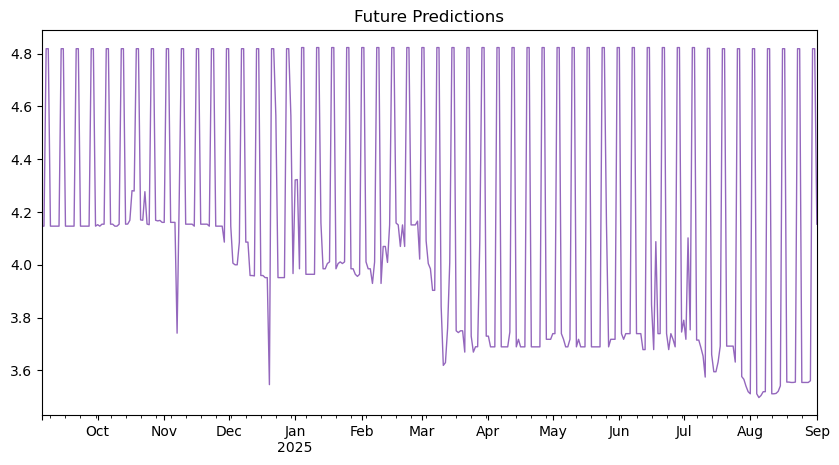

In [82]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()